In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def read_tdms(tdms_file, datalen):
    ncol = int(tdms_file.properties['strips'])
    nrow = int(tdms_file.properties['bottom pixel'] - tdms_file.properties['top pixel'] + 1)
    data_cube = np.zeros((int(ncol*nrow), datalen))
    idx = 0
    for group in tdms_file.groups():
        group_name = group.name
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            data = channel[:]
            data_cube[idx,:] = data
            idx = idx + 1
        break
    data_cube = np.reshape(data_cube, ((ncol, nrow, datalen)))
        
    for group in tdms_file.groups():
        group_name = group.name
        if group_name == 'Spectra':
            continue
        for channel in group.channels():
            channel_name = channel.name
            properties = channel.properties
            waves = channel[:]
            break    
        
    return waves, data_cube

In [3]:
path_int = '241221/nps_in_glycerol/mg110_glyc_33.tdms'
pathbc = '241221/nps_in_glycerol/mg110_glyc_WC34.tdms'
pathdc = '241221/nps_in_glycerol/mg110_glyc_DC35.tdms'

wave_raw, inten_raw = read_tdms(tdms_file=TdmsFile.read(path_int), datalen=670)
w1, dc_raw =     read_tdms(tdms_file=TdmsFile.read(pathdc), datalen=1340)
w2, bc_raw =    read_tdms(tdms_file=TdmsFile.read(pathbc),  datalen=1340)

dc = dc_raw[1:][::2]
bc = bc_raw[1:][::2]



In [15]:
waves = wave_raw[77:-68]
I = inten_raw[:,:,77:-68] # dim 0-1: x and y, dim 2: wavelength
dc_avg = np.mean(dc.reshape(8000, 670)[:,77:-68], axis=0)
bc_avg = np.mean(bc.reshape(8000, 670)[:,77:-68], axis=0)


DFS_NPs = (I) / (bc_avg - dc_avg)


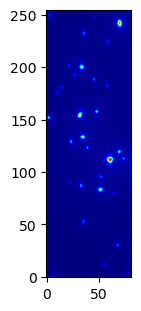

In [16]:
fig, ax = plt.subplots(1,1, figsize=[3,3], layout='compressed')
from scipy import ndimage

                        # bottom:top, right:left
DFS_NPs_cropped = DFS_NPs[12:-10, 5:-1]
DFS_summed_waves = np.sum(DFS_NPs_cropped, axis=-1)
    
rotated_img = ndimage.rotate(DFS_summed_waves, 90)

ax.imshow(rotated_img, origin='lower', cmap='jet')#, vmin=100, vmax=200)


ind_max = np.unravel_index(np.argmax(DFS_summed_waves, axis=None), DFS_summed_waves.shape)
ind_min = np.unravel_index(np.argmin(DFS_summed_waves, axis=None), DFS_summed_waves.shape)

## Fit Gaussians ## 

In [17]:
scaled = 1E2
def fit_2Dgauss(M, a, x0, c1, y0, c2, d):
    x, y = M
    return 1E5*a*np.exp(-((x-x0)**2 / (2*(c1)**2) + (y-y0)**2 / (2*(c2)**2))) + d*scaled


In [18]:
def find_the_NP(initial_data):
    ## Will sum all the wavelengths to located the NPs
    yrange = np.linspace(0, initial_data.shape[0], initial_data.shape[0])[::-1]
    xrange = np.linspace(0, initial_data.shape[1], initial_data.shape[1])
    datainit = initial_data
    X, Y = np.meshgrid(xrange, yrange)
    xdata = np.vstack((X.ravel(), Y.ravel()))
    Z = datainit.ravel()

    idxmax = np.argmax(Z)

    p0_x0 = xdata[0, idxmax]
    p0_y0 = xdata[1, idxmax]
    
    if p0_x0 == 0: p0_x0 = 0.1
    if p0_y0 == 0: p0_y0 = 0.1

     ##############################
    ind_max = np.unravel_index(np.argmax(datainit, axis=None), datainit.shape)       
        
    
    p0 = [5, p0_x0, 1, p0_y0, 1, 1]
    
    bounds = [[1,  p0_x0*0.95, 0.5, p0_y0*0.95,  0.5,  0],
              [10, p0_x0*1.05, 3,   p0_y0*1.05,    3, 100]]

    popt, pcov = curve_fit(fit_2Dgauss, xdata, Z, p0)#, bounds=bounds)

    
    
    fitdata = fit_2Dgauss(xdata, *popt).reshape(len(yrange), len(xrange))
    xyminmax = [np.min(X), np.max(X), np.min(Y), np.max(Y)]
    sbtrct_data = datainit-fitdata
    return xyminmax, datainit, fitdata, sbtrct_data, popt, xdata, ind_max


In [23]:
numparts = 50

all_data_init = []
all_fit_data = []
all_sbtrct_data = []
all_popt = []
all_indmax = []


xyminmax_i0, datainit_i0, fitdata_i0, sbtrct_data_i0, popt_i0, xdata_i0, ind_max0 = find_the_NP(initial_data=DFS_summed_waves)

all_data_init.append(datainit_i0)
all_fit_data.append(fitdata_i0)
all_sbtrct_data.append(sbtrct_data_i0)
all_popt.append(popt_i0)
all_indmax.append(ind_max0)

vmini = np.min(datainit_i0)
vmaxi = np.max(datainit_i0)

initial_data = sbtrct_data_i0

for i in range(numparts-1):
    xyminmax_i, datainit_i, fitdata_i, sbtrct_data_i, popt_i, _, ind_max = find_the_NP(initial_data=initial_data)
    all_data_init.append(datainit_i)
    all_fit_data.append(fitdata_i)

    all_sbtrct_data.append(sbtrct_data_i)
    all_popt.append(popt_i)
    all_indmax.append(ind_max)
    
    initial_data = sbtrct_data_i

(61, 143)


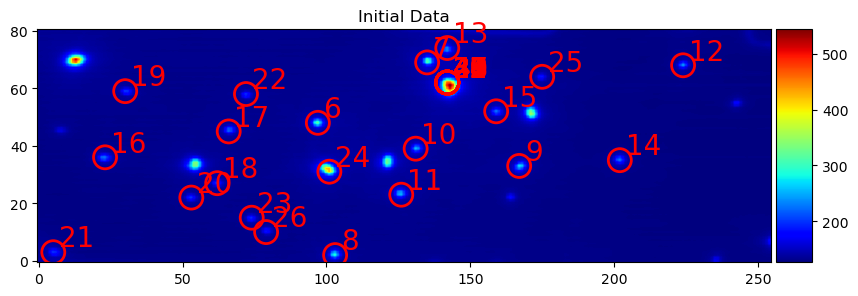

In [24]:
    
fig, ax = plt.subplots(1,1, figsize=[10,13])


print(all_indmax[0])

## Initial Data ##


im_init = ax.imshow(all_data_init[0],
             vmin=vmini, vmax=vmaxi,
             origin='lower',
#              extent=(xyminmax_i0),
             cmap='jet')

ax.set_title('Initial Data')
divider = make_axes_locatable(ax)
cax_ij = divider.append_axes("right", size="5%", pad=0.05)
cbarij = plt.colorbar(im_init, cax=cax_ij)


start=6

for i in range(start, numparts):
    ax.add_patch(plt.Circle([all_indmax[i][1], all_indmax[i][0]], radius=4, edgecolor='r',lw=2, fill=False))        
    ax.annotate(str(i), fontsize=20, xy=[all_indmax[i][1]+2, all_indmax[i][0]+2],color='red')


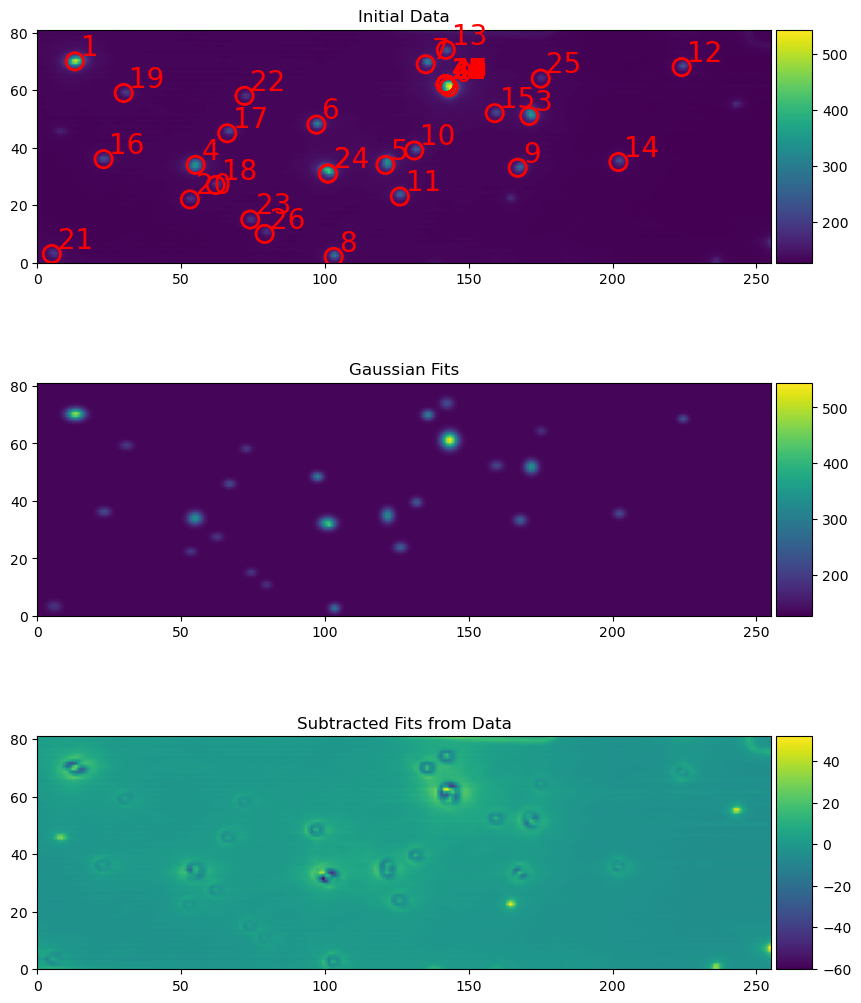

In [25]:
    
fig, ax = plt.subplots(3,1, figsize=[10,13])

## Initial Data ##
im_init = ax[0].imshow(all_data_init[0],
             vmin=vmini, vmax=vmaxi,
             origin='lower',
             extent=(xyminmax_i0))
ax[0].set_title('Initial Data')
divider = make_axes_locatable(ax[0])
cax_ij = divider.append_axes("right", size="5%", pad=0.05)
cbarij = plt.colorbar(im_init, cax=cax_ij)



## Gaussian Fits ##
im_gaus = ax[1].imshow(np.sum(all_fit_data,axis=0),
            vmin=vmini, vmax=vmaxi,
             origin='lower',
             extent=(xyminmax_i0))
ax[1].set_title('Gaussian Fits')
divider = make_axes_locatable(ax[1])
cax_ij = divider.append_axes("right", size="5%", pad=0.05)
cbarij = plt.colorbar(im_gaus, cax=cax_ij)


## Subtracted Fits from Data ##
im_sub = ax[2].imshow(all_sbtrct_data[-1],
#             vmin=vmini, vmax=vmaxi,
             origin='lower',
             extent=(xyminmax_i0))
ax[2].set_title('Subtracted Fits from Data');
divider = make_axes_locatable(ax[2])
cax_ij = divider.append_axes("right", size="5%", pad=0.05)
cbarij = plt.colorbar(im_sub, cax=cax_ij)

color = cm.jet(np.linspace(0, 1, numparts))

for i in range(numparts):
    ax[0].add_patch(plt.Circle([all_indmax[i][1], all_indmax[i][0]], radius=3, edgecolor='r',lw=2, fill=False))        
    ax[0].annotate(str(i), fontsize=20, xy=[all_indmax[i][1]+2, all_indmax[i][0]+2],color='red')
#     print(all_popt[i][-1])

In [26]:
## Let's look at NP 1

NPi = 19

# Center NP pixel
x = all_indmax[NPi][0]
y = all_indmax[NPi][1]

### We actually will need to fit a Gaussian to each wavelength :/
I_back = np.zeros(DFS_NPs_cropped.shape[-1])

for wave_i in range(DFS_NPs_cropped.shape[-1]):
    data_smallwind = DFS_NPs_cropped[x-5:x+5, y-5:y+5, wave_i]
    try:
        _, _, fitdata_i, _, popt_i, _, _ = find_the_NP(initial_data=data_smallwind)
    except RuntimeError:
        pass
    I_back[wave_i] = popt_i[-1]*scaled
    
    
DFS = DFS_NPs_cropped - I_back 

[ 21. 116. 695.]


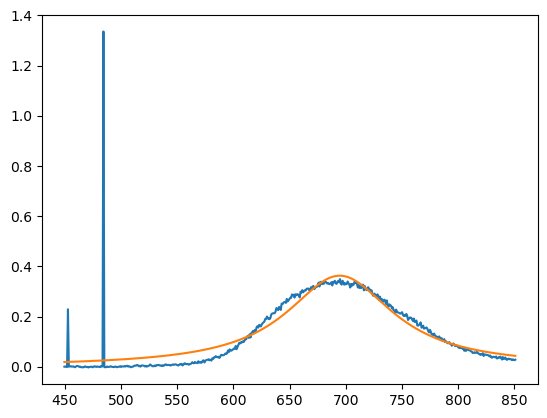

In [27]:
def fit_lorentz(wave, A, Gam, wave0):
    return A * 0.5 * Gam / ((wave-wave0)**2+ (0.5*Gam)**2)


plt.plot(waves, DFS[x, y, :])

p0 = [1, 30, 700]
popt, pcov = curve_fit(fit_lorentz, waves, DFS[x, y, :], p0)#, bounds=bounds)

print(np.round(popt))

plt.plot(waves, fit_lorentz(waves, *popt))



(571, 15)


(500.0, 900.0)

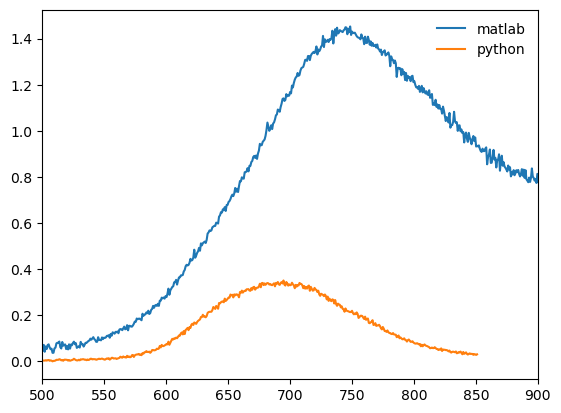

In [30]:
import scipy.io
mat = scipy.io.loadmat('241221/nps_in_glycerol/mg110_glyc_33/all_spectra_mg110_glyc_33.mat')
allSpec = mat['allSpec']
waves_mat = mat['rawwvlths'].reshape(571,1)

print(allSpec.shape)
plt.plot(waves_mat, allSpec[:,1], label='matlab')

NPi = 19

# Center NP pixel
x = all_indmax[NPi][0]
y = all_indmax[NPi][1]

### We actually will need to fit a Gaussian to each wavelength :/
I_back = np.zeros(DFS_NPs_cropped.shape[-1])

for wave_i in range(DFS_NPs_cropped.shape[-1]):
    data_smallwind = DFS_NPs_cropped[x-5:x+5, y-5:y+5, wave_i]
    try:
        _, _, fitdata_i, _, popt_i, _, _ = find_the_NP(initial_data=data_smallwind)
    except RuntimeError:
        pass
    I_back[wave_i] = popt_i[-1]*scaled
    

DFS = DFS_NPs_cropped - I_back 
plt.plot(waves, DFS[x, y, :], label='python')#/max(DFS[x, y, :]))

plt.legend(frameon=False)
plt.xlim([500,900])